In this notebook, we wil use tooks in the analytics engine to calculate HDDs on census tracts.

In [2]:
from climakitae.new_core.user_interface import ClimateData
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from climakitae.new_core.data_access.data_access import DataCatalog
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.tools.derived_variables import compute_hdd_cdd

cd = ClimateData()

catalog = DataCatalog()
census_tracts = catalog.boundaries._ca_census_tracts

#select an arbitraty sample of 10 census tracts
my_tracts = census_tracts.iloc[20:30]

2025-12-29 17:30:39 - climakitae.new_core.user_interface - INFO - Initializing ClimateData interface
2025-12-29 17:30:39 - climakitae.new_core.dataset_factory - INFO - DatasetFactory initialized with 3 validators and 10 processors
2025-12-29 17:30:39 - climakitae.new_core.user_interface - INFO - ClimateData initialization successful
2025-12-29 17:30:39 - climakitae.new_core.user_interface - INFO - ✅ Ready to query!


In [3]:
list(my_tracts['GEOID'].values)

['06073021900',
 '06073020026',
 '06073020028',
 '06073013421',
 '06029005402',
 '06071008402',
 '06033000502',
 '06071003506',
 '06073000400',
 '06053000101']

In [4]:
tracts_wrf = (cd.catalog("cadcat")
        .activity_id("WRF")
        .variable("t2")
        .table_id("day")
        .grid_label("d03")
        .processes(
            {
                "warming_level": {
                    "warming_levels": [0.8,2.0],
                },
                "clip": {"boundaries": list(my_tracts['GEOID'].values), "separated": True},
                "convert_units": "degF"
            }
        )
        .get()
    )

2025-12-29 17:30:39 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2025-12-29 17:30:39 - climakitae.new_core.user_interface - INFO - Activity ID set to: WRF
2025-12-29 17:30:39 - climakitae.new_core.user_interface - INFO - Variable set to: t2
2025-12-29 17:30:39 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2025-12-29 17:30:39 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2025-12-29 17:30:39 - climakitae.new_core.user_interface - INFO - Processes set: 3 operations configured
2025-12-29 17:30:39 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': 'WRF', 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 't2', 'station_id': UNSET, 'network_id': UNSET, 'processes': {'warming_level': {'warming_levels': [0.8, 2.0]}, 'clip': {'boundaries': ['06073021900', '0607302002

In [5]:
tracts_wrf

<xarray.Dataset> Size: 1GB
Dimensions:            (census_tract: 10, sim: 5, warming_level: 2,
                        time_delta: 10950, y: 20, x: 17)
Coordinates: (12/13)
  * warming_level      (warming_level) float64 16B 0.8 2.0
  * x                  (x) float64 136B -4.191e+06 -4.188e+06 ... -3.975e+06
  * y                  (y) float64 160B 6.559e+05 6.589e+05 ... 1.532e+06
  * time_delta         (time_delta) int64 88kB -5475 -5474 -5473 ... 5473 5474
  * sim                (sim) object 40B 'WRF_UCLA_TaiESM1_ssp370_day_d03_r1i1...
    lakemask           (census_tract, y, x) float32 14kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    ...                 ...
    lat                (census_tract, y, x) float32 14kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    lon                (census_tract, y, x) float32 14kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    simulation         <U40 160B 'WRF.UCLA.TaiESM1.ssp370.day.d03.r1i1p1f1'
    centered_year      (warming_level) int64 16B 2011 2040
    Lambert_Conformal  int64 8B 0
  * census_tract       (census_tract) <U11 440B '06073021900' ... '06053000101'
Data variables:
    t2                 (census_tract, sim, warming_level, time_delta, y, x) float32 1GB dask.array<chunksize=(1, 1, 1, 3546, 1, 1), meta=np.ndarray>
Attributes: (12/121)
    AERCU_FCT:                        1.0
    AERCU_OPT:                        0
    AUTO_LEVELS_OPT:                  2
    BL_PBL_PHYSICS:                   1
    BOTTOM-TOP_GRID_DIMENSION:        40
    BOTTOM-TOP_PATCH_END_STAG:        40
    ...                               ...
    clip:                             Process 'clip' applied to the data. Sep...
    convert_units:                    Process 'convert_units' applied to the ...
    update_attributes:                Process 'update_attributes' applied to ...
    filter_unadjusted_models:         yes
    concat:                           Process 'concat' applied to the data. T...
    warming_level_simple:             Process 'warming_level_simple' applied ...

In [6]:
tract_median = tracts_wrf.median(['x','y']).t2
#rename so this works nicely with the cdd/hdd function
tract_median = tract_median.rename("Air Temperature at 2m")

In [7]:
hdd, cdd = compute_hdd_cdd(tract_median, hdd_threshold=65, cdd_threshold=65) # Set for all data within selected DFZ zone

In [8]:
cdd = cdd.compute()
hdd = hdd.compute()

In [9]:
# calculate annual average total cdd/hdd
cdd_annual = add_dummy_time_to_wl(cdd).squeeze().groupby("time.year").sum(["time"]).mean('year')
hdd_annual = add_dummy_time_to_wl(hdd).squeeze().groupby("time.year").sum(["time"]).mean('year')

In [10]:
cdd_annual = cdd_annual.compute()
hdd_annual = hdd_annual.compute()


In [11]:
cdd_annual_mmmean = cdd_annual.mean('sim')
hdd_annual_mmmean = hdd_annual.mean('sim')

In [12]:
# transform into dataframe for export
cdd_df = cdd_annual.to_dataframe()

In [19]:
cdd_df = cdd_df.reset_index()

In [25]:
cdd_annual.to_dataframe().to_csv("test.csv")

In [24]:
pivot_df = cdd_df.pivot(
            index='census_tract', 
            columns=['warming_level', 'sim'], 
            values='Cooling Degree Days'
        )

In [27]:
pivot_df.to_csv("sample_census_tract_data.csv")

In [ ]:
pivot_df.columns = [f'{sim} - {warming_level}' for sim, warming_level in pivot_df.columns]

In [26]:
pivot_df[

MultiIndex([(0.8,       'WRF_UCLA_TaiESM1_ssp370_day_d03_r1i1p1f1'),
            (2.0,       'WRF_UCLA_TaiESM1_ssp370_day_d03_r1i1p1f1'),
            (0.8,        'WRF_UCLA_MIROC6_ssp370_day_d03_r1i1p1f1'),
            (2.0,        'WRF_UCLA_MIROC6_ssp370_day_d03_r1i1p1f1'),
            (0.8, 'WRF_UCLA_EC-Earth3-Veg_ssp370_day_d03_r1i1p1f1'),
            (2.0, 'WRF_UCLA_EC-Earth3-Veg_ssp370_day_d03_r1i1p1f1'),
            (0.8, 'WRF_UCLA_MPI-ESM1-2-HR_ssp370_day_d03_r3i1p1f1'),
            (2.0, 'WRF_UCLA_MPI-ESM1-2-HR_ssp370_day_d03_r3i1p1f1'),
            (0.8,     'WRF_UCLA_EC-Earth3_ssp370_day_d03_r1i1p1f1'),
            (2.0,     'WRF_UCLA_EC-Earth3_ssp370_day_d03_r1i1p1f1')],
           names=['warming_level', 'sim'])

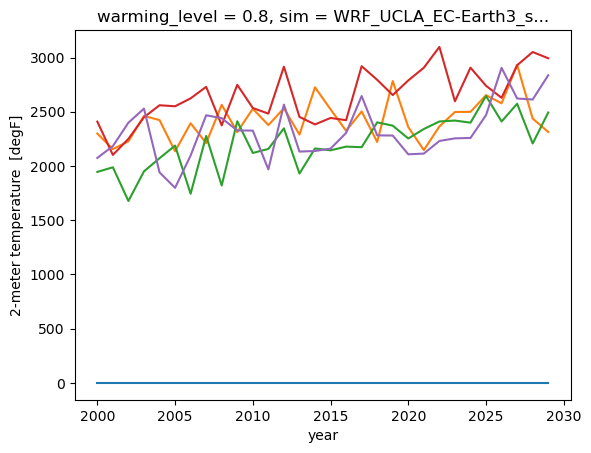

In [14]:
for sim in cdd_annual.sim:
    cdd_annual.sel(sim=sim).isel(census_tract=0,warming_level=0).plot()